In [0]:
# Automatically reload external libraries that change
%reload_ext autoreload
%autoreload 2

# If a matplotlib plot command is issued, display the results in the notebook
%matplotlib inline

In [2]:
# Upload data
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [3]:
!tar xvzf track_shower_images.tar.gz

Images/
Images/Hits/
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_0_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_100_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_101_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_102_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_103_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_104_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_105_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_106_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_107_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_108_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_109_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_10_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_110_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_111_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_112_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_113_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_114_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_115_0.png
Images/Hits/Image_DUNEFD_MC1

In [4]:
# Upload supporting python modules
!rm -f *.py
from google.colab import files
files.upload()

Saving data.py to data.py
Saving img_util.py to img_util.py
Saving model_util.py to model_util.py
Saving transforms.py to transforms.py
Saving unet.py to unet.py


{'data.py': b'import numpy as np\nimport torch\nimport os\nimport PIL\nfrom torch.utils.data import Dataset\nfrom torch.utils.data import DataLoader\n\ndef open_image(path):\n    img = PIL.Image.open(path)\n    if img.mode  != \'L\':\n        img = img.convert(\'L\')\n    return img\n\nclass SegmentationDataset(Dataset):\n    """Dataset suitable for segmentation tasks."""\n\n    def __init__(self, image_dir, mask_dir, filenames, transform=None):\n        """\n        Args:\n            root_dir (string): Directory with all images and masks.\n            image_dir (string): The relative directory containing the images.\n            mask_dir (string): The relative directory containing the masks.\n            transform (callable, optional): Optional transform to be applied\n                on a sample.\n        """\n        self.image_dir = image_dir\n        self.mask_dir = mask_dir\n        self.transform = transform\n        self.filenames = filenames\n        self.mean = 0.\n        s

In [0]:
from data import SegmentationBunch
from transforms import Rescale, ToTensor
from unet import UNet
import img_util as iu
import model_util as mu

In [0]:
from data import open_image
img = open_image("Images/Truth/Image_DUNEFD_MC11_CaloHitListW_0_0.png")

In [7]:
img.size

(512, 208)

In [0]:
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.optim as opt
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# This line is important for GPU running, otherwise some weights end up on the CPU - not sure where - maybe Kaiming reinit?
torch.set_default_tensor_type(torch.cuda.FloatTensor)
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
bunch = SegmentationBunch("Images", "Hits", "Truth", batch_size=48, valid_pct = 0.2,
    transform=transforms.Compose([ToTensor(True)]))
#bunch = SegmentationBunch("Images", "Hits", "Truth", batch_size=16, valid_pct = 0.2,
#    transform=transforms.Compose([ToTensor(True)]))

In [0]:
def count_classes(dl, num_classes):
    count = {key: 0 for key in range(num_classes)}
    for batch in dl:
        _, truth = batch
        unique, counts = torch.unique(truth, return_counts=True)
        unique = [ u.item() for u in unique ]
        counts = [ c.item() for c in counts ]
        this_dict = dict(zip(unique, counts))
        for key in this_dict:
                count[key] += this_dict[key]
    return count

In [11]:
print(count_classes(bunch.train_dl, 3))
print(count_classes(bunch.valid_dl, 3))

{0: 81564034, 1: 95659, 2: 129235}
{0: 20393304, 1: 22160, 2: 31768}


In [0]:
import numpy as np
from torch.optim.lr_scheduler import LambdaLR
from torch.autograd import Variable

def get_exponential_factor(start, stop, n, epoch):
    ratio = stop / start
    factor = ratio ** (1. / (n - 1))
    return factor ** epoch

def get_linear_factor(start, stop, n, epoch):
    target = start + (epoch / (n - 1.)) * (stop - start)
    return target / start

class LRFinder():
    def __init__(self, model, bunch, loss_fn, optim, num_iter, void_code,
                 low_lr=1e-7, high_lr=2, is_exponential=True):
        self.num_iter = num_iter
        if is_exponential:
            self.lambda_func = lambda batch : get_exponential_factor(low_lr, high_lr, self.num_iter, batch)
        else:
            self.lambda_func = lambda batch : get_linear_factor(low_lr, high_lr, self.num_iter, batch)
        self.scheduler = LambdaLR(optim, lr_lambda=self.lambda_func)
        self.learner = UNetLearner(model, bunch, loss_fn, optim, self.scheduler, void_code)
    
    def find(self):
        num_epochs = int(np.floor(self.num_iter/len(self.learner.bunch.train_dl)))
        for epoch in list(range(num_epochs)):
            # This is ugly, finder needs to know too much about learner
            train_dl = self.learner.bunch.train_dl
            for i, batch in enumerate(train_dl):
                self.learner.is_training = True
                self.learner._batch(epoch, i, batch)
                self.learner.evaluate()
    
    def get_lrs(self):
        return torch.Tensor(self.learner.history["lr"]).cpu()

    def get_losses(self):
        num_batches = len(self.learner.bunch.valid_dl)
        x = torch.Tensor(self.learner.history["val_loss"])
        x = x.reshape(x.size(0) // num_batches, num_batches).mean(axis = 1)
        return x.cpu()

    def get_accuracies(self):
        num_batches = len(self.learner.bunch.valid_dl)
        x = torch.Tensor(self.learner.history["val_acc"])
        x = x.reshape(x.size(0) // num_batches, num_batches).mean(axis = 1)
        return x.cpu()

In [0]:
SHOWER = 1
TRACK = 2

def switch_batch_norm(model, track_running_stats):
    for group in model.children():
        if type(group) == nn.Sequential:
            for child in group:
                if type(child) == nn.BatchNorm2d:
                    child.track_running_stats = track_running_stats

def summarize_epoch(history, n_train_batches, n_valid_batches):
    epoch = len(history["train_loss"]) // n_train_batches
    train_loss = torch.Tensor(history["train_loss"][-n_train_batches:]).mean()
    train_acc = torch.Tensor(history["train_acc"][-n_train_batches:]).mean()
    valid_loss = torch.Tensor(history["val_loss"][-n_valid_batches:]).mean()
    valid_acc = torch.Tensor(history["val_acc"][-n_valid_batches:]).mean()
    valid_acc_shower = torch.Tensor(history["val_acc_shower"][-n_valid_batches:]).mean()
    valid_acc_track = torch.Tensor(history["val_acc_track"][-n_valid_batches:]).mean()

    print("Epoch {} : Training Loss {:.3f} Acc {:.3f} Validation Loss {:.3f} " \
          "Acc {:.3f} T Acc {:.3f} S Acc {:.3f}".format(epoch, train_loss,
          train_acc, valid_loss, valid_acc, valid_acc_track, valid_acc_shower))

class UNetLearner:
    def __init__(self, model, bunch, loss_fn, optim, scheduler, void_code=0):
        self.model = model
        self.bunch = bunch
        self.loss_fn = loss_fn
        self.optim = optim
        self.scheduler = scheduler
        self.void_code = void_code
        self.is_training = True
        self.verbose = 0
        self.history = {"lr" : [], "train_loss" : [], "train_acc" : [],
                        "train_acc_shower" : [], "train_acc_track" : [],
                        "val_loss" : [], "val_acc" : [],
                        "val_acc_shower" : [], "val_acc_track" : []}

    def train(self, n_epochs):
        self.model = self.model.cuda()
        for e in range(n_epochs):
            # Train
            self.is_training = True
            self.model = self.model.train()
            self._epoch(e)
            torch.save(model.state_dict(), f'unet_{e}.pkl')
            # Load later with:
            # model.load_state_dict(torch.load(PATH))
            # model.eval()
            # Validate
            self.model = self.model.eval()
            switch_batch_norm(self.model, False)
            with torch.no_grad():
                self.evaluate(e)
            switch_batch_norm(self.model, True)
            summarize_epoch(self.history, len(self.bunch.train_dl),
                            len(bunch.valid_dl))
    
    def evaluate(self, e):
        self.is_training = False
        self._epoch(e)

    def _batch(self, e, b, batch):
        images, truth = batch
        x = Variable(images).cuda()
        y = Variable(truth).cuda()
        pred = self.model.forward(x)
        loss = self.loss_fn(pred, y)

        key = "train" if self.is_training else "val"
        if self.is_training:
            self.history["lr"].append(self.scheduler.get_lr()[0])
        self.history[f"{key}_loss"].append(loss.item())
        self.history[f"{key}_acc"].append(self.accuracy(pred, y))
        self.history[f"{key}_acc_track"].append(self.accuracy(pred, y, TRACK))
        self.history[f"{key}_acc_shower"].append(self.accuracy(pred, y, SHOWER))

        if not self.is_training and self.verbose > 0:
            if self.verbose > 1: #and b == (len(self.bunch.valid_dl) - 1):
                net_input = x.cpu().detach().numpy()
                net_pred = pred.cpu().detach().numpy()
                net_mask = y.cpu().detach().numpy()
                iu.show_batch(e, b, net_input, net_pred, net_mask, self.void_code,
                            self.is_training, n = images.shape[0], randomize=False)
                label = "Training" if self.is_training else "Validation"
                print("Batch {}: {} Loss: {:.3f} Acc: {:.3f} S Acc: {:.3f} T Acc: {:.3f}".format(
                    b + 1, label, loss.item(), self.history[f"{key}_acc"][-1],
                    self.history[f"{key}_acc_shower"][-1], self.history[f"{key}_acc_track"][-1]))                
            elif e == 4:    # Should add epochs to self on call to train
                net_input = x.cpu().detach().numpy()
                net_pred = pred.cpu().detach().numpy()
                net_mask = y.cpu().detach().numpy()
                iu.show_batch(e, b, net_input, net_pred, net_mask, self.void_code,
                            self.is_training, n = images.shape[0], randomize=False)
                label = "Training" if self.is_training else "Validation"
                print("Batch {}: {} Loss: {:.3f} Acc: {:.3f} S Acc: {:.3f} T Acc: {:.3f}".format(
                    b + 1, label, loss.item(), self.history[f"{key}_acc"][-1],
                    self.history[f"{key}_acc_shower"][-1], self.history[f"{key}_acc_track"][-1]))

        if self.is_training:
            loss.backward()
            self.optim.step()
            self.scheduler.step()
            self.optim.zero_grad()

    def _epoch(self, epoch):
        dl = self.bunch.train_dl if self.is_training else self.bunch.valid_dl
        for i, batch in enumerate(dl):
            self._batch(epoch, i, batch)
    
    def set_verbose(self, verbose):
        self.verbose = verbose

    def accuracy(self, input, truth, type=None):
        target = truth.squeeze(1)
        if type is None:
            mask = target != self.void_code
        else:
            mask = target == type
        return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [14]:
def get_class_weights(n_track, n_shower, n_void):
    weights = [1. / n_void, 1. / n_shower, 1. / n_track]
    return [weight / sum(weights) for weight in weights]

n_track = 127659
n_shower = 95973
n_void = 81565296
weights = get_class_weights(n_track, n_shower, n_void)
weights

[0.0006712271831704981, 0.5704608991961062, 0.42886787362072315]

In [0]:
class LRExponentialOneCycle(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optim, base_lr, max_lr, min_lr, total_batches, pct_start=0.2, last_epoch=-1):
        self.optim = optim
        self.total_steps = total_batches
        self.n_increasing_steps = int(total_batches * pct_start)
        self.n_decreasing_steps = total_batches - self.n_increasing_steps
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.min_lr = min_lr
        if last_epoch == -1:
            for idx, group in enumerate(self.optim.param_groups):
                group['lr'] = base_lr
                group['max_lr'] = max_lr
                group['min_lr'] = min_lr
        super(LRExponentialOneCycle, self).__init__(optim, last_epoch)
    
    def anneal(self, start, stop, n):
        ratio = stop / start
        factor = ratio ** (1. / (n - 1))
        if self.last_epoch < self.n_increasing_steps:
            epoch = self.last_epoch
        else:
            epoch = 1 + self.last_epoch - self.n_increasing_steps
        return start * factor ** epoch

    def get_lr(self):
        lrs = []
        step_num = self.last_epoch
        if step_num < self.n_increasing_steps:
            lr = self.anneal(self.base_lr, self.max_lr, self.n_increasing_steps)
        elif step_num < self.total_steps:
            lr = self.anneal(self.max_lr, self.min_lr, 1 + self.n_decreasing_steps)
        else:
            lr = self.min_lr
        lrs.append(lr)
        return lrs

In [0]:
# Create the network, loss function and optimizer
from torch.optim.lr_scheduler import OneCycleLR, LambdaLR
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
num_epochs = 5
n_classes = 3
#max_lr = 5e-3
#max_lr = 1e-2
#max_lr = 1e-1
max_lr = 3e-2
base_lr = 1e-5
min_lr = 1e-7
div_factor = max_lr / base_lr
final_factor = base_lr / min_lr
model = UNet(1, n_classes = n_classes, n_filters = 16, y_range = (0, n_classes))
loss_fn = nn.CrossEntropyLoss(torch.tensor(weights))
optim = opt.Adam(model.parameters(), lr=max_lr, weight_decay=1e-6)
# Standard One-Cycle LR
#scheduler = OneCycleLR(optim, max_lr, anneal_strategy='linear', total_steps = num_epochs * len(bunch.train_dl), pct_start=0.30, div_factor=div_factor, final_div_factor=10)
# Exp One-Cycle LR
#scheduler = LRExponentialOneCycle(optim, base_lr, max_lr, min_lr, num_epochs * len(bunch.train_dl), pct_start=0.5)
# Exp decay LR
#scheduler = LambdaLR(optim, lr_lambda=lambda batch : get_exponential_factor(max_lr, min_lr, num_epochs * len(bunch.train_dl), batch))
# Constant LR
#scheduler = LambdaLR(optim, lr_lambda=lambda batch : 1.)
# Linear decay LR
#scheduler = LambdaLR(optim, lr_lambda=lambda batch : get_linear_factor(max_lr, min_lr, num_epochs * len(bunch.train_dl), batch))
# Linear One-Cycle LR
#scheduler = OneCycleLR(optim, max_lr, anneal_strategy='linear', total_steps = num_epochs * len(bunch.train_dl), pct_start=0.50, div_factor=div_factor, final_div_factor=final_factor)
# Cosine One-Cycle LR
scheduler = OneCycleLR(optim, max_lr, anneal_strategy='cos', total_steps = num_epochs * len(bunch.train_dl), pct_start=0.50, div_factor=div_factor, final_div_factor=final_factor)
learner = UNetLearner(model, bunch, loss_fn, optim, scheduler)

In [0]:
def explore_learning_rates(weight_decays):
    lrs = []
    losses = []
    accuracies = []
    for wd in weight_decays:
        seed = 42
        np.random.seed(seed)
        torch.manual_seed(seed)
        model = UNet(1, n_classes = n_classes, n_filters = 16, y_range = (0, n_classes))
        loss_fn = nn.CrossEntropyLoss(torch.tensor(weights))
        optim = opt.Adam(model.parameters(), lr=1e-7, weight_decay=wd)
        lr_finder = LRFinder(model, bunch, loss_fn, optim, 96, 0, low_lr=1e-7, high_lr=10)
        lr_finder.find()
        lrs.append(lr_finder.get_lrs())
        losses.append(lr_finder.get_losses())
        accuracies.append(lr_finder.get_accuracies())
    return lrs, losses, accuracies

In [0]:
lrs, losses, accuracies = explore_learning_rates([0., 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7])

In [0]:
def plot_lr(lrs, losses, accuracies, name, labels=("lr", "loss", "acc")):
    fig, ax = plt.subplots()
    ax.set_title('Learning Rate Finder')
    ax.set_xlabel("lr")
    ax.set_xscale("log")
    ax.plot(lrs, losses, c='black', label="Loss")
    ax.plot(lrs, accuracies, c='red', label="Accuracy")
    plt.legend()
    iu.save_figure(fig, name)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

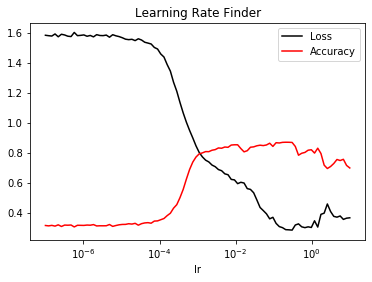

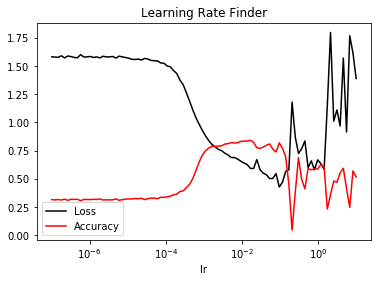

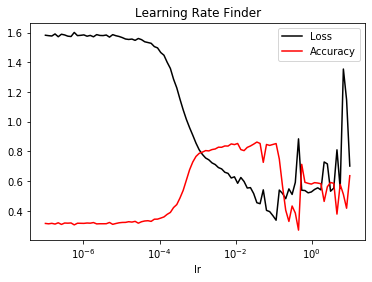

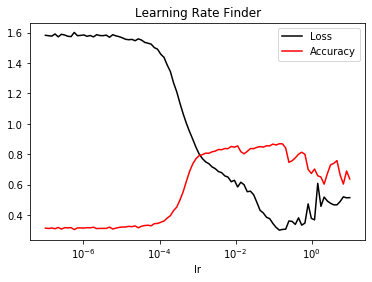

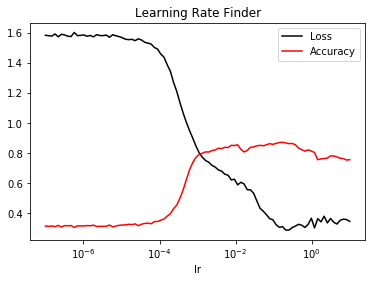

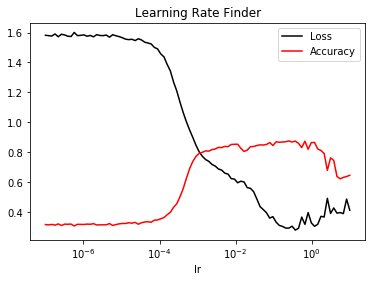

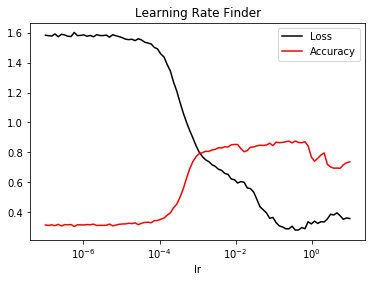

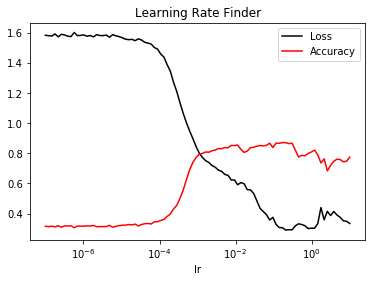

In [0]:
for i in range(len(lrs)):
    plot_lr(lrs[i], losses[i], accuracies[i], f"LearningRateFinder_{i}")

In [0]:
def plot_lr_variable(lrs, vars, label, name, wds):
    fig, ax = plt.subplots(figsize=(15,10))
    ax.set_title('')
    ax.set_xlabel("lr", fontsize=20)
    ax.set_xscale("log")
    ax.set_ylabel(label, fontsize=20)
    plt.tick_params(labelsize=20)
    for i in range(len(vars)):
        if i > 2:
            ax.plot(lrs, vars[i], label=f"wd = {wds[i]:.0E}")
        else:
            ax.plot(lrs, vars[i], label=f"wd = {wds[i]}")
    plt.legend(prop={'size': 20})
    iu.save_figure(fig, name)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


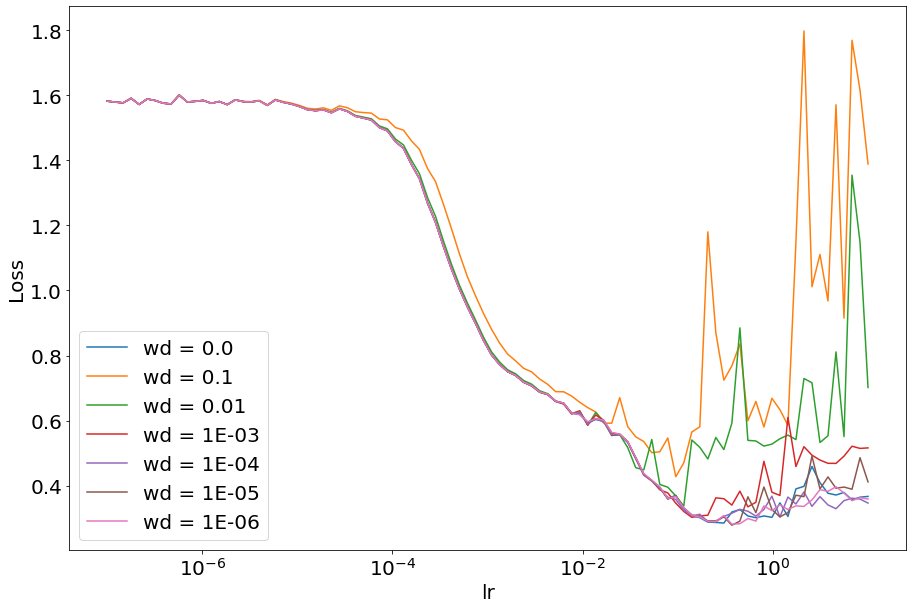

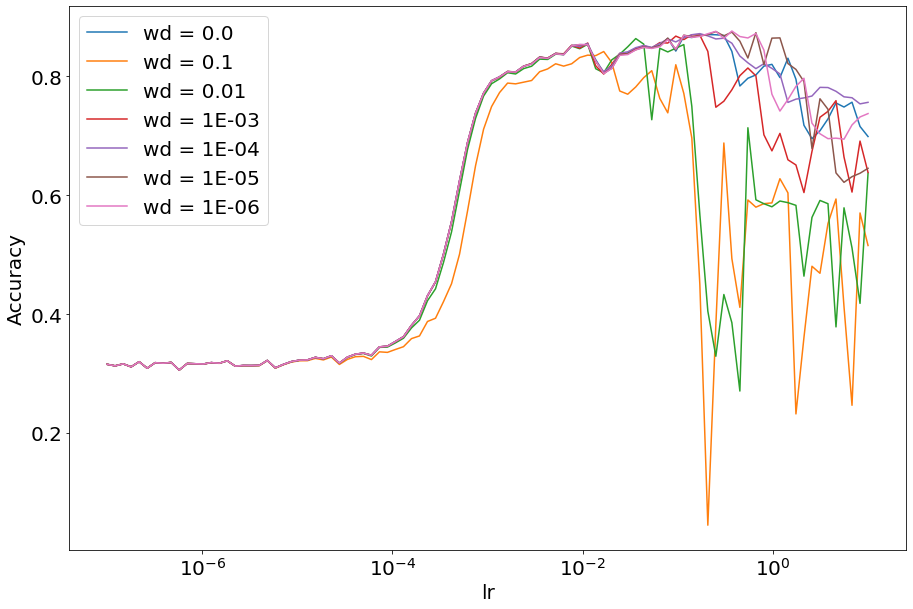

In [0]:
from operator import itemgetter
wds = [0., 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
sub_wds = itemgetter(0, 1, 2, 3, 4, 5, 6)(wds)
sub_losses = itemgetter(0, 1, 2, 3, 4, 5, 6)(losses)
sub_accuracies = itemgetter(0, 1, 2, 3, 4, 5, 6)(accuracies)
plot_lr_variable(lrs[0], sub_losses, "Loss", "LRFinderLosses", sub_wds)
plot_lr_variable(lrs[0], sub_accuracies, "Accuracy", "LRFinderAccuracies", sub_wds)

In [0]:
!tar cvzf images.tar.gz *.png *.pdf *.eps

LearningRateFinder_0.png
LearningRateFinder_1.png
LearningRateFinder_2.png
LearningRateFinder_3.png
LearningRateFinder_4.png
LearningRateFinder_5.png
LearningRateFinder_6.png
LearningRateFinder_7.png
LossByLearningRate.png
LRFinderAccuracies.png
LRFinderLosses.png
LearningRateFinder_0.pdf
LearningRateFinder_1.pdf
LearningRateFinder_2.pdf
LearningRateFinder_3.pdf
LearningRateFinder_4.pdf
LearningRateFinder_5.pdf
LearningRateFinder_6.pdf
LearningRateFinder_7.pdf
LossByLearningRate.pdf
LRFinderAccuracies.pdf
LRFinderLosses.pdf
LearningRateFinder_0.eps
LearningRateFinder_1.eps
LearningRateFinder_2.eps
LearningRateFinder_3.eps
LearningRateFinder_4.eps
LearningRateFinder_5.eps
LearningRateFinder_6.eps
LearningRateFinder_7.eps
LossByLearningRate.eps
LRFinderAccuracies.eps
LRFinderLosses.eps


In [0]:
files.download("images.tar.gz")

In [28]:
# Register hooks for feature map visualisation
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.c1.register_forward_hook(get_activation('ResBlock1'))
model.c2.register_forward_hook(get_activation('ResBlock2'))
model.c3.register_forward_hook(get_activation('ResBlock3'))
model.c4.register_forward_hook(get_activation('ResBlock4'))
model.c5.register_forward_hook(get_activation('Bridge'))
model.c6.register_forward_hook(get_activation('TransConvBlock4'))
model.c7.register_forward_hook(get_activation('TransConvBlock3'))
model.c8.register_forward_hook(get_activation('TransConvBlock2'))
model.c9.register_forward_hook(get_activation('TransConvBlock1'))

In [0]:
learner.set_verbose(1)

Epoch 1 : Training Loss 0.914 Acc 0.624 Validation Loss 0.622 Acc 0.824 T Acc 0.775 S Acc 0.895
Epoch 2 : Training Loss 0.529 Acc 0.824 Validation Loss 0.384 Acc 0.858 T Acc 0.846 S Acc 0.873
Epoch 3 : Training Loss 0.321 Acc 0.861 Validation Loss 0.299 Acc 0.846 T Acc 0.755 S Acc 0.977
Epoch 4 : Training Loss 0.279 Acc 0.871 Validation Loss 0.269 Acc 0.872 T Acc 0.807 S Acc 0.964
Batch 1: Validation Loss: 0.298 Acc: 0.851 S Acc: 0.956 T Acc: 0.779
Batch 2: Validation Loss: 0.257 Acc: 0.888 S Acc: 0.970 T Acc: 0.836
Batch 3: Validation Loss: 0.241 Acc: 0.887 S Acc: 0.947 T Acc: 0.850
Batch 4: Validation Loss: 0.259 Acc: 0.873 S Acc: 0.937 T Acc: 0.816
Epoch 5 : Training Loss 0.268 Acc 0.877 Validation Loss 0.264 Acc 0.875 T Acc 0.820 S Acc 0.952


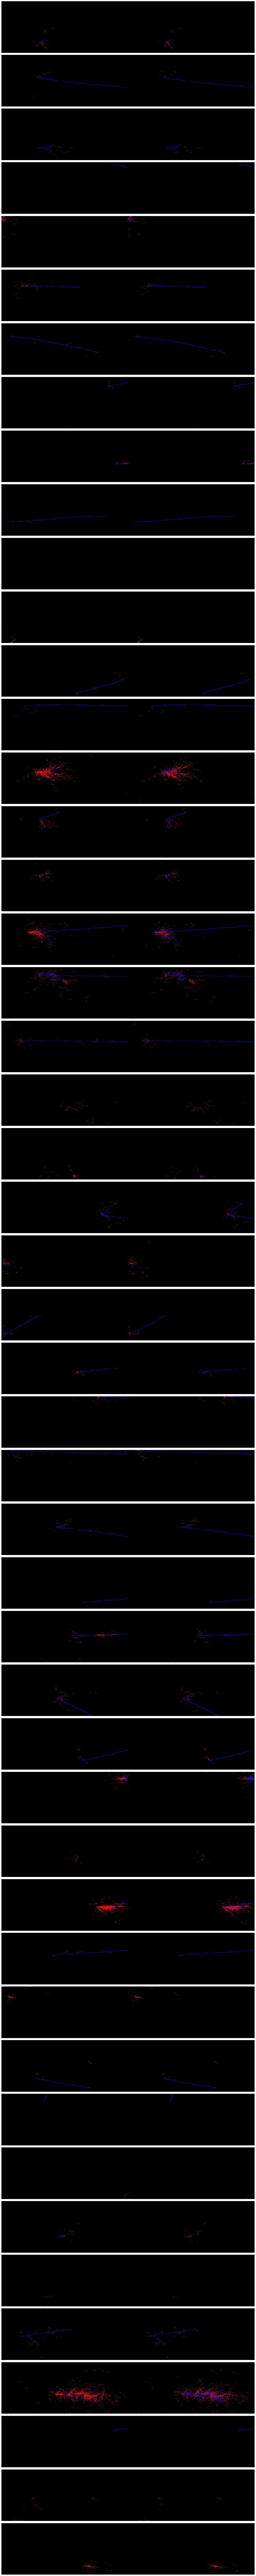

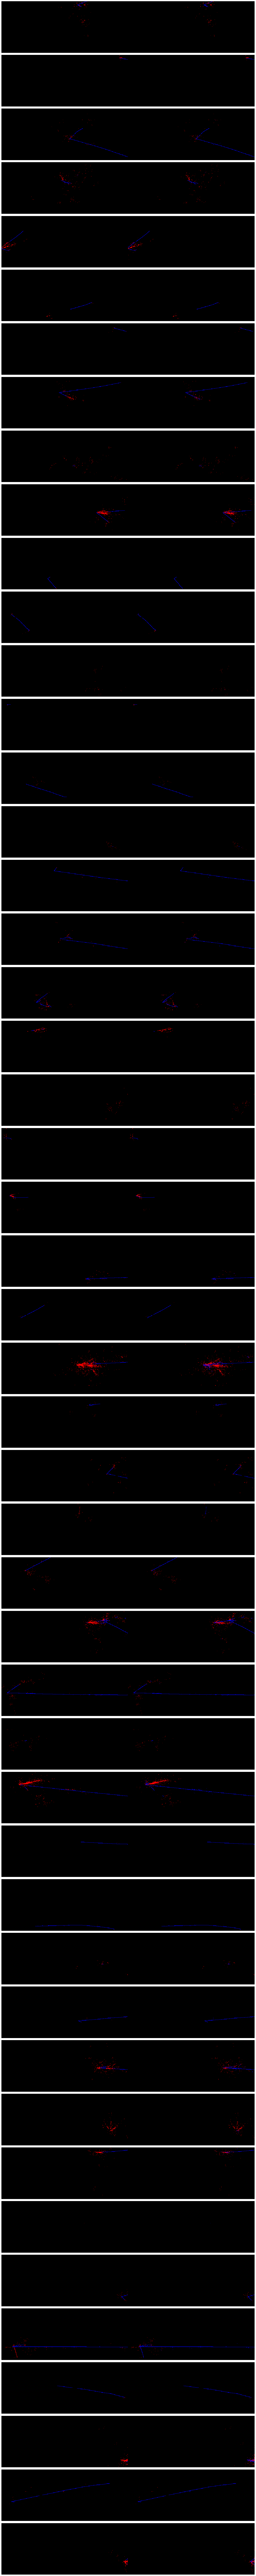

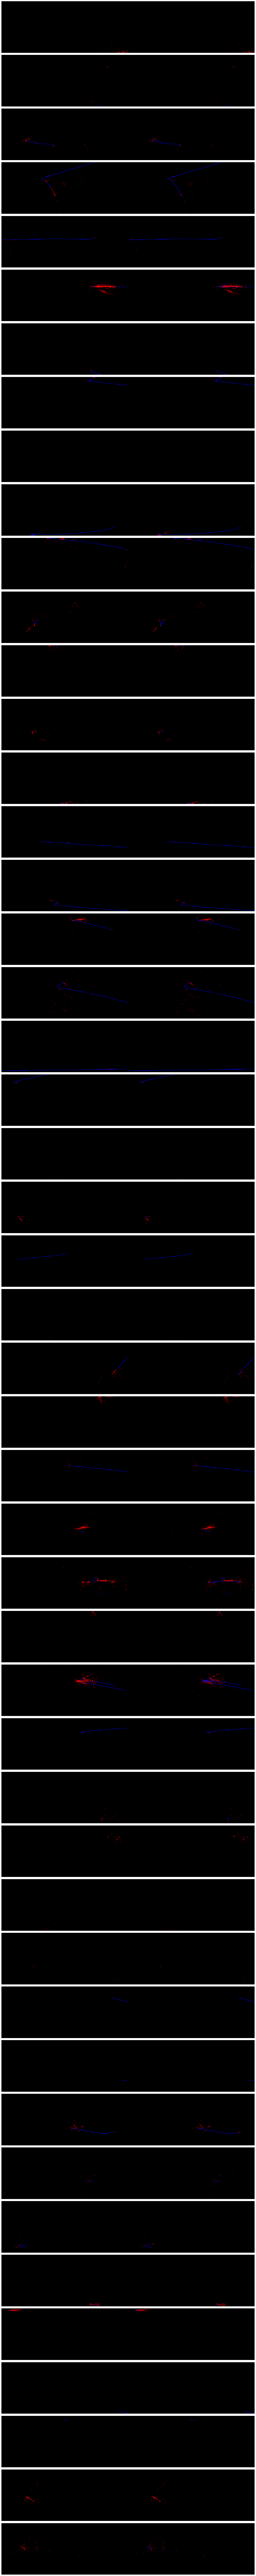

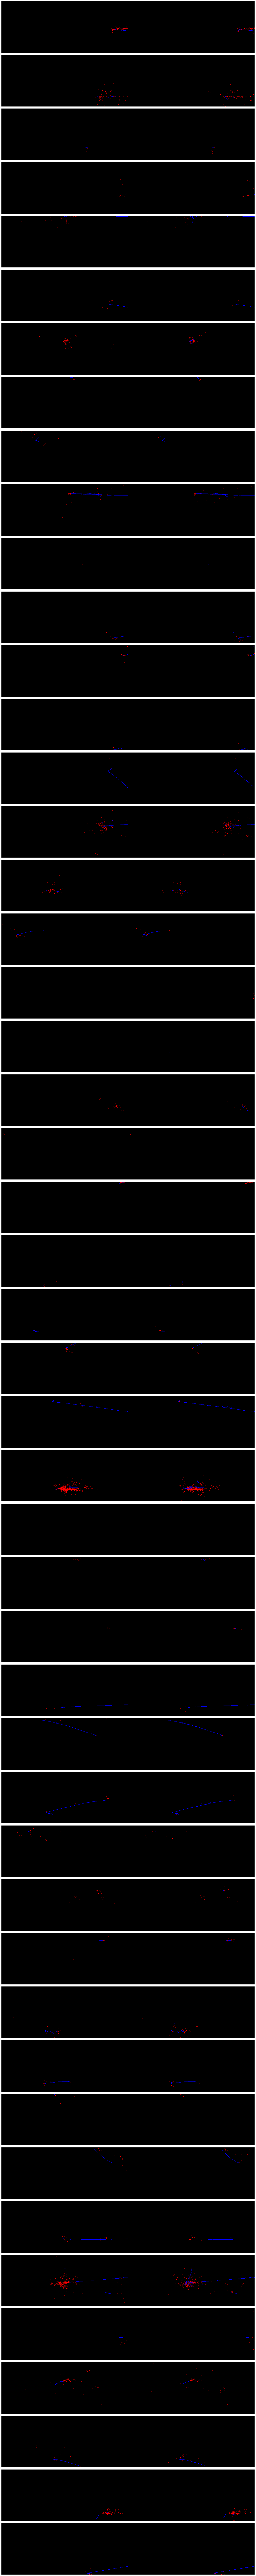

In [30]:
# Run
num_epochs=5
learner.train(num_epochs)

In [0]:
lrs1 = learner.history["lr"]
losses1 = learner.history["train_loss"]
accuracies1 = learner.history["train_acc"]
val_lrs1 = (learner.history["lr"])[::4]
val_losses1 = learner.history["val_loss"]
val_accuracies1 = learner.history["val_acc"]

In [0]:
lrs = []
losses = []
accuracies = []
val_lrs = []
val_losses = []
val_accuracies = []

In [0]:
lrs.append(lrs1)
losses.append(losses1)
accuracies.append(accuracies1)
val_lrs.append(val_lrs1)
val_losses.append(val_losses1)
val_accuracies.append(val_accuracies1)

In [0]:
def batch_to_epoch(values, batches_per_epoch):
    x = torch.Tensor(values)
    x = x.reshape(x.size(0) // batches_per_epoch, batches_per_epoch)
    return x.mean(axis = 1).cpu()

def plot_lr_loss_acc(lrs, losses, accuracies, name, labels=None):
    fig, axs = plt.subplots(3, 1, figsize=(10,15), sharex=True)
    yy = np.array([lrs, losses, accuracies])
    axes = ["lr", "loss", "acc"]
    for i, ax in enumerate(axs):
        ax.set_xlabel("batch", fontsize=20)
        ax.set_ylabel(axes[i], fontsize=20)
        if len(yy[i].shape) == 1:
            ax.plot(range(len(yy[i])), yy[i])
        else:
            for j, y in enumerate(yy[i]):
                ax.plot(range(len(y)), y, label=labels[j])
    for ax in axs:
        ax.label_outer()
        ax.tick_params(labelsize=20)
    plt.tight_layout()
    plt.legend(prop={'size': 20})
    iu.save_figure(fig, name)

def plot_loss_acc(learner, n_train_batches, n_val_batches, name):
    fig, ax = plt.subplots(figsize=(15,10))
    training_losses = batch_to_epoch(learner.history["train_loss"], n_train_batches)
    training_accuracies = batch_to_epoch(learner.history["train_acc"], n_train_batches)
    val_losses = batch_to_epoch(learner.history["val_loss"], n_val_batches)
    val_accuracies = batch_to_epoch(learner.history["val_acc"], n_val_batches)
    xx = range(1, 1 + len(training_losses))
    ax.set_xlabel("epoch", fontsize=20)
    ax.plot(xx, training_losses, c='black', label="Training loss")
    ax.plot(xx, training_accuracies, c='red', label="Training accuracy")
    ax.plot(xx, val_losses, c='blue', label="Validation loss")
    ax.plot(xx, val_accuracies, c='cyan', label="Validation accuracy")
    plt.tick_params(labelsize=20)
    plt.tight_layout()
    plt.legend(prop={'size': 20})
    iu.save_figure(fig, name)

def plot_loss_acc_by_type(learner, n_train_batches, n_val_batches, name):
    fig, ax = plt.subplots(figsize=(15,10))
    training_losses = batch_to_epoch(learner.history["train_loss"], n_train_batches)
    training_accuracies = batch_to_epoch(learner.history["train_acc"], n_train_batches)
    val_losses = batch_to_epoch(learner.history["val_loss"], n_val_batches)
    val_accuracies = batch_to_epoch(learner.history["val_acc"], n_val_batches)
    val_accuracies_track = batch_to_epoch(learner.history["val_acc_track"], n_val_batches)
    val_accuracies_shower = batch_to_epoch(learner.history["val_acc_shower"], n_val_batches)
    xx = range(1, 1 + len(training_losses))
    ax.set_xlabel("epoch", fontsize=20)
    ax.plot(xx, training_losses, label="Train loss")
    ax.plot(xx, training_accuracies, label="Train acc")
    ax.plot(xx, val_losses, label="Val loss")
    ax.plot(xx, val_accuracies, label="Val acc")
    ax.plot(xx, val_accuracies_track, label="Val track acc")
    ax.plot(xx, val_accuracies_shower, label="Val shower acc")
    plt.tick_params(labelsize=20)
    plt.tight_layout()
    plt.legend(prop={'size': 20})
    iu.save_figure(fig, name)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


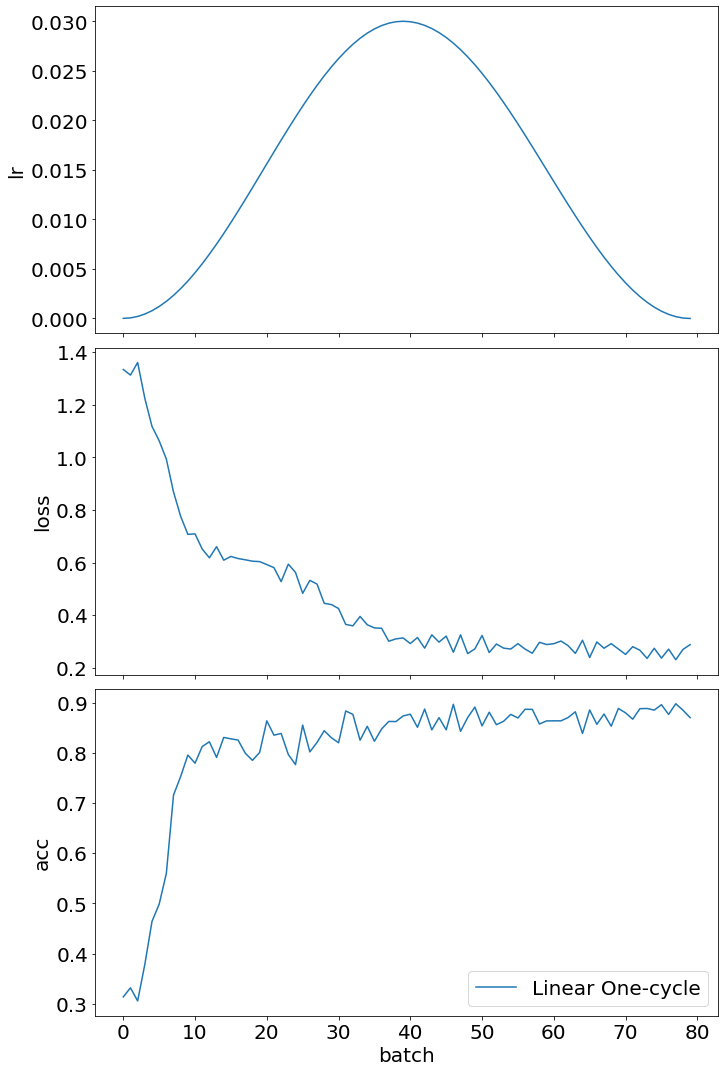

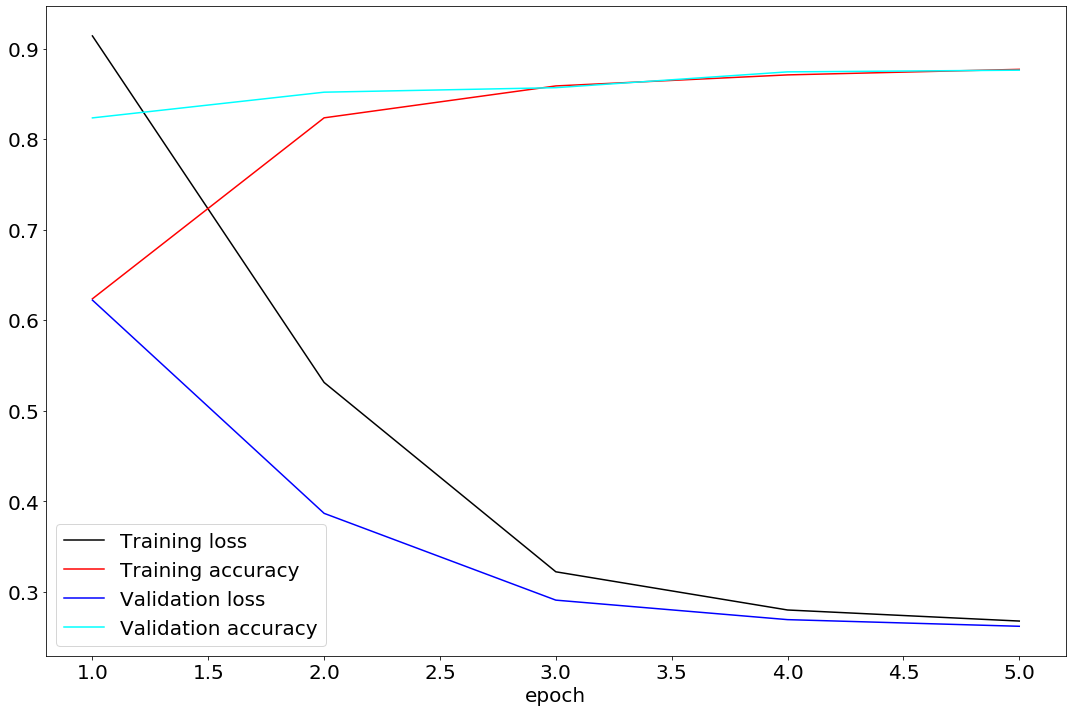

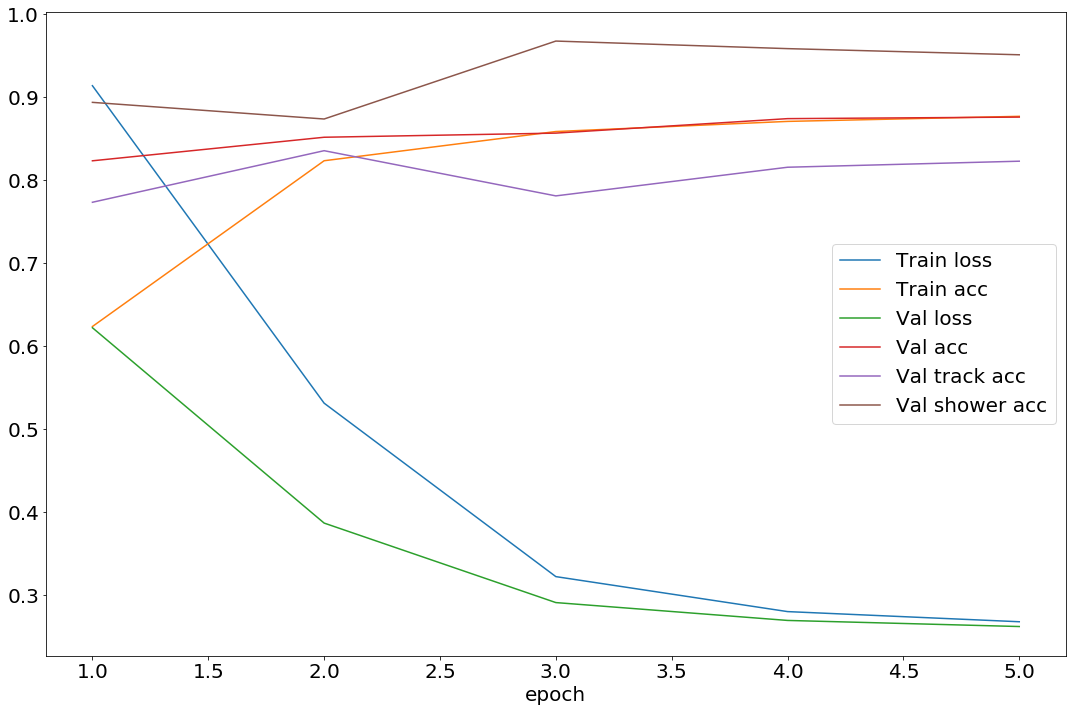

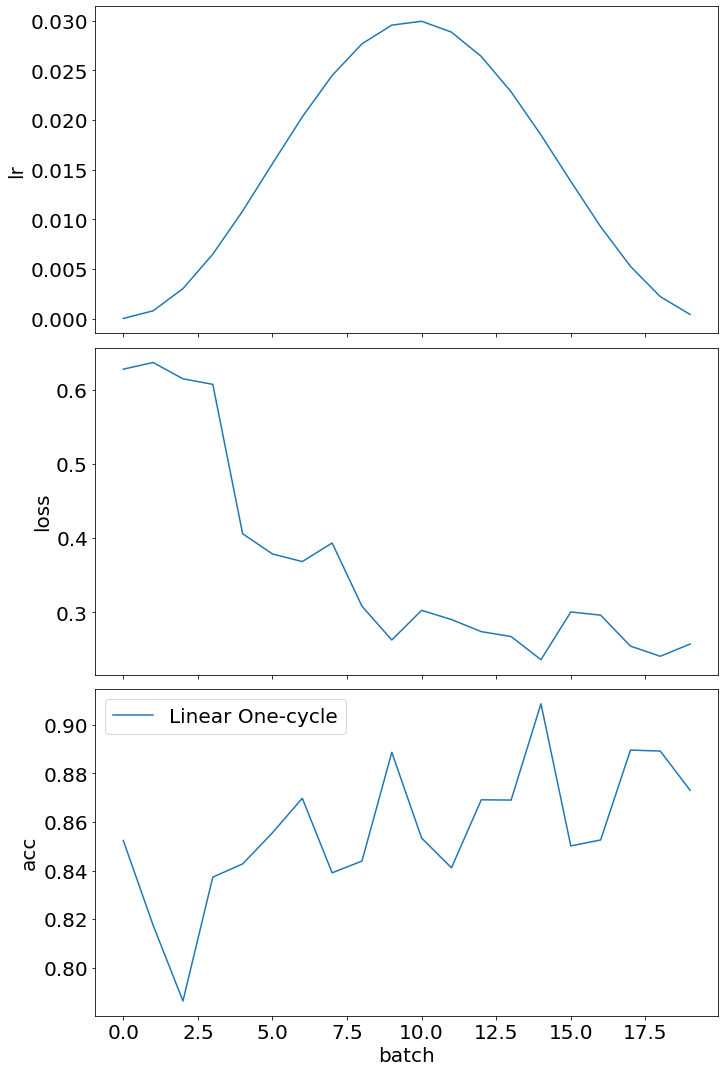

In [0]:
plot_lr_loss_acc(lrs, losses, accuracies, "LRLossAccByBatch", labels=["Linear One-cycle", "Constant", "Exp decay", "Linear decay", "Cosine One-cycle"])
plot_loss_acc(learner, len(bunch.train_dl), len(bunch.valid_dl), "TrainingByEpoch")
plot_loss_acc_by_type(learner, len(bunch.train_dl), len(bunch.valid_dl), "DetailByEpoch")
#plot_lr_loss_acc(val_lrs, val_losses, val_accuracies, "ValLRLossAccByBatch", labels=["Max LR=5e-3", "Max LR=1e-2", "Max LR=1e-1", "Max LR=3e-2"])
plot_lr_loss_acc(val_lrs, val_losses, val_accuracies, "ValLRLossAccByBatch", labels=["Linear One-cycle", "Constant", "Exp decay", "Linear decay", "Cosine One-cycle"])

In [38]:
!tar cvzf images.tar.gz *.png *.pdf # *.eps *.npy
files.download("images.tar.gz")

Bridge_0.png
Bridge_10.png
Bridge_11.png
Bridge_12.png
Bridge_13.png
Bridge_14.png
Bridge_15.png
Bridge_16.png
Bridge_17.png
Bridge_18.png
Bridge_19.png
Bridge_1.png
Bridge_20.png
Bridge_21.png
Bridge_22.png
Bridge_23.png
Bridge_24.png
Bridge_25.png
Bridge_26.png
Bridge_27.png
Bridge_28.png
Bridge_29.png
Bridge_2.png
Bridge_30.png
Bridge_31.png
Bridge_32.png
Bridge_33.png
Bridge_34.png
Bridge_35.png
Bridge_36.png
Bridge_37.png
Bridge_38.png
Bridge_39.png
Bridge_3.png
Bridge_40.png
Bridge_41.png
Bridge_42.png
Bridge_43.png
Bridge_44.png
Bridge_45.png
Bridge_46.png
Bridge_47.png
Bridge_4.png
Bridge_5.png
Bridge_6.png
Bridge_7.png
Bridge_8.png
Bridge_9.png
ResBlock1_0.png
ResBlock1_10.png
ResBlock1_11.png
ResBlock1_12.png
ResBlock1_13.png
ResBlock1_14.png
ResBlock1_15.png
ResBlock1_16.png
ResBlock1_17.png
ResBlock1_18.png
ResBlock1_19.png
ResBlock1_1.png
ResBlock1_20.png
ResBlock1_21.png
ResBlock1_22.png
ResBlock1_23.png
ResBlock1_24.png
ResBlock1_25.png
ResBlock1_26.png
ResBlock1_27.png


In [39]:
!ls -l *.gz

-rw-r--r-- 1 root root 15632147 Dec  8 14:20 images.tar.gz
-rw-r--r-- 1 root root   840513 Dec  8 13:09 track_shower_images.tar.gz


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


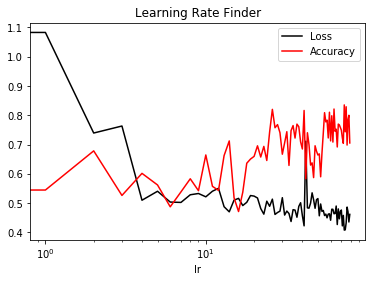

In [0]:
plot_lr(list(range(len(lrs))), losses, accuracies, "Training", labels=("lr", "loss", "acc"))

In [34]:
len(activation["ResBlock1"])

48

[ 0  1  2  5  8  9 11 13 14]
[ 4  7 10 12 18 19 24 26 27]
[ 2  4 10 38 40 41 45 47 50]
[  9  20  39  63  86  93 115 119 123]
[ 30  55  63  78 100 117 171 182 191]
[  5  10  17  37  62  81  84  85 127]
[10 22 23 32 40 46 54 58 59]
[ 1  3  6 18 23 26 27 28 31]
[ 1  2  6  7  9 11 13 14 15]


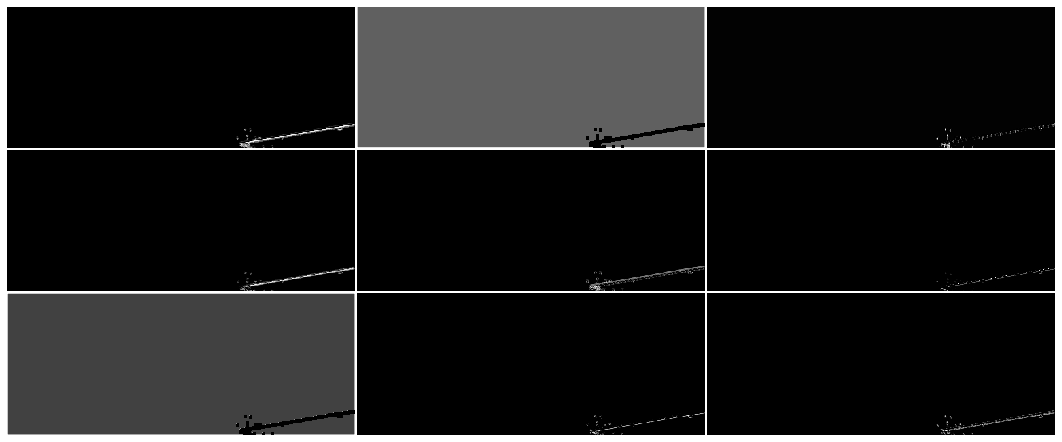

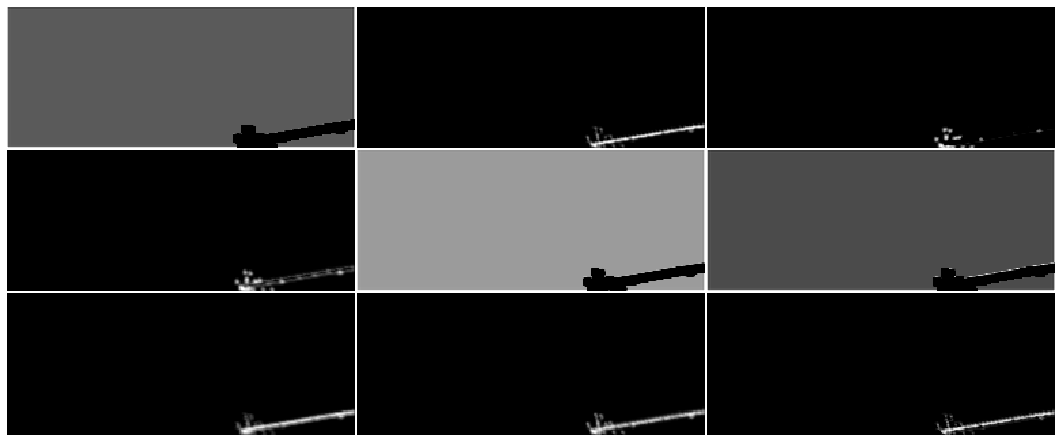

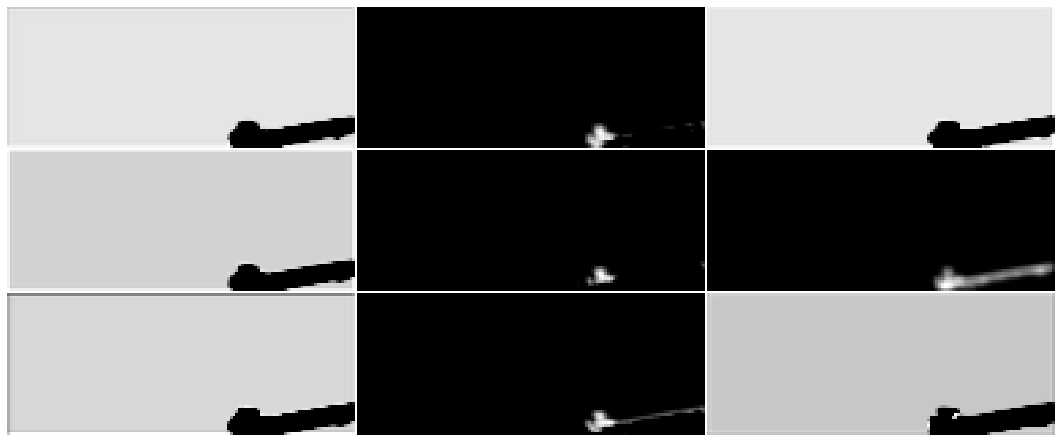

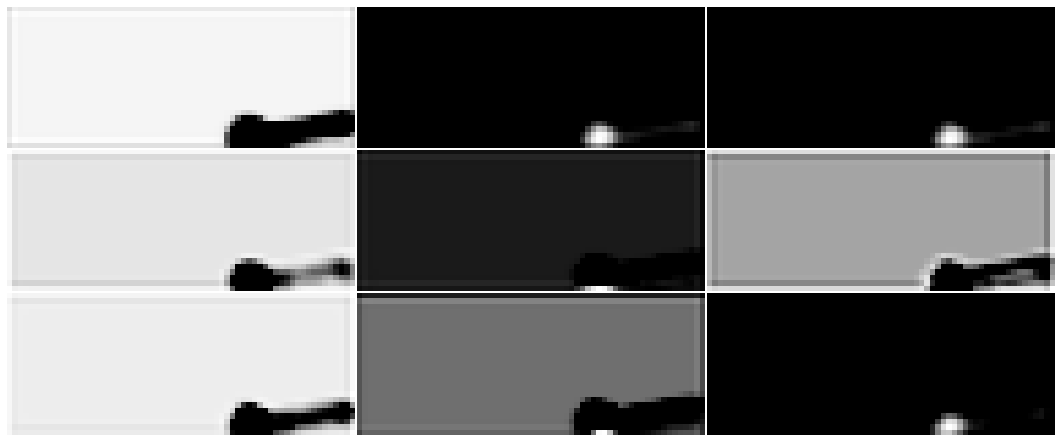

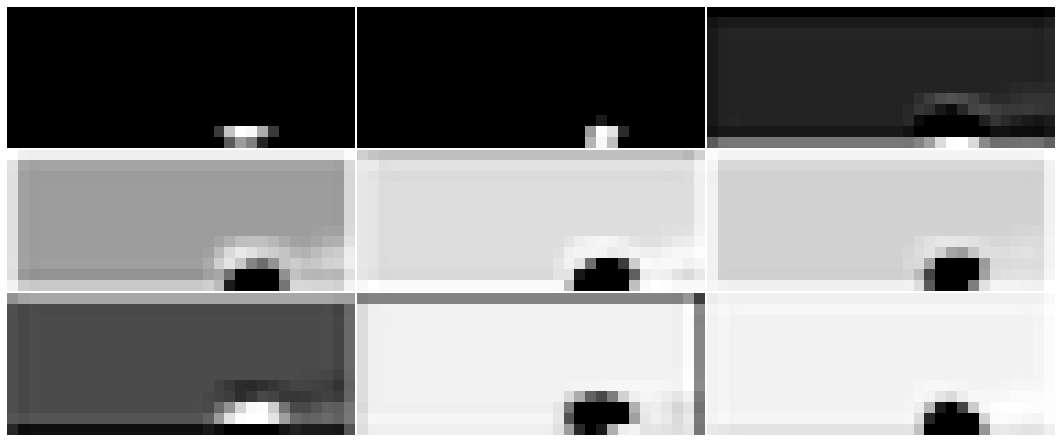

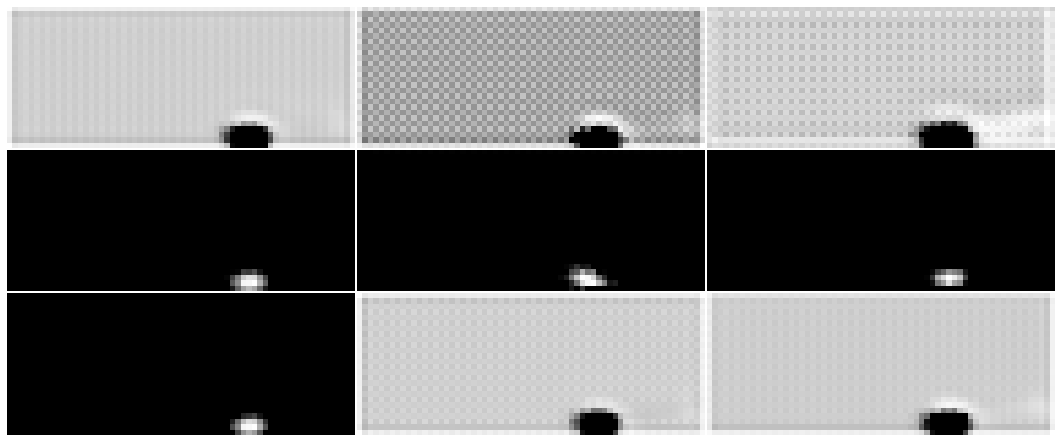

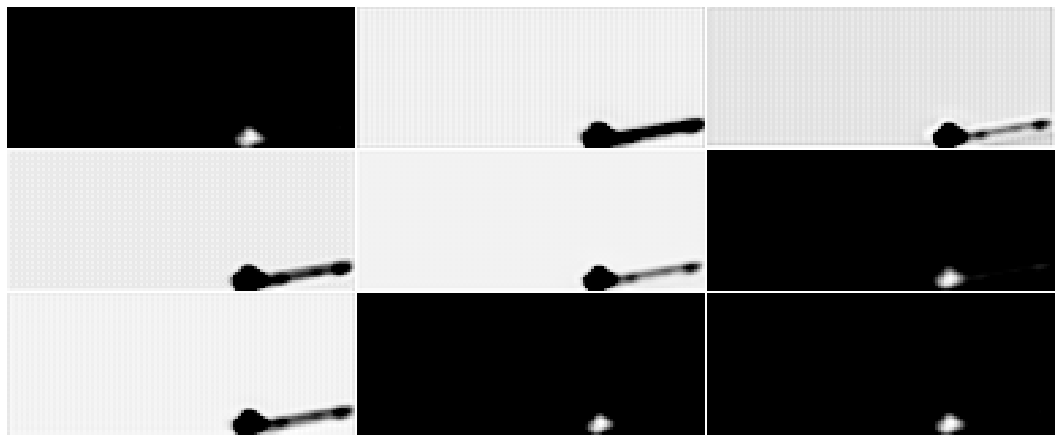

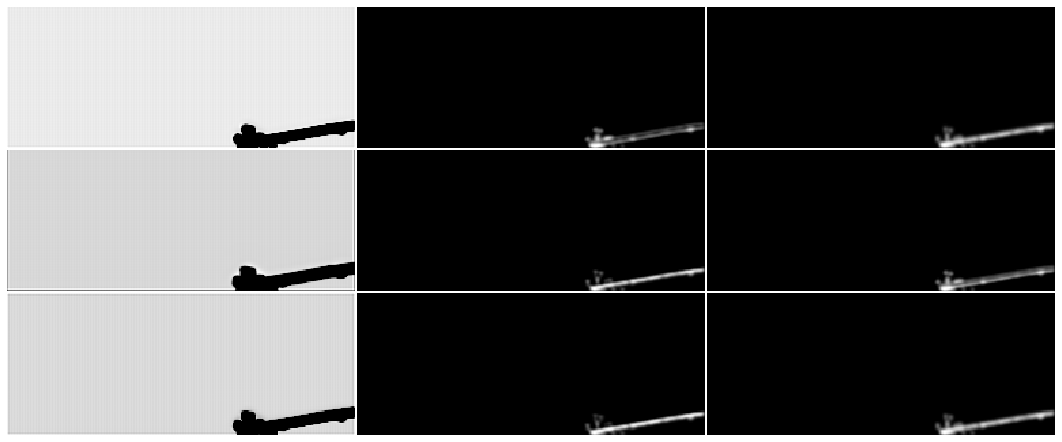

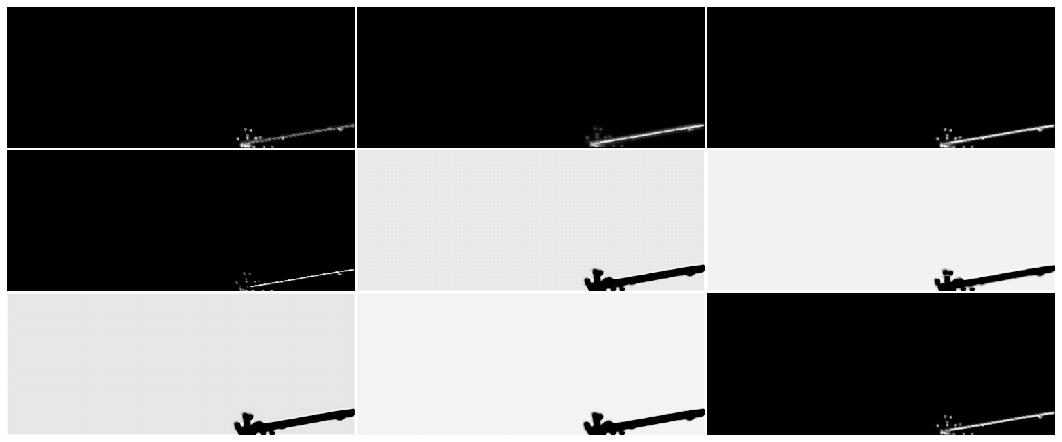

In [35]:
# Visualize feature maps
names = ['ResBlock1','ResBlock2','ResBlock3','ResBlock4','Bridge',
         'TransConvBlock4','TransConvBlock3','TransConvBlock2','TransConvBlock1']
for name in names:
    act = activation[name].squeeze()
    choices = np.sort(np.random.choice(list(range(act.size(1))), size = 9, replace = False))
    act = act[:,choices]
    fig, ax = plt.subplots(act.size(1) // 3, act.size(1) // 3, figsize=(15,6))
    print(choices)
    for img_idx in range(len(act)):#[3, 19, 26, 27, 37]:
        tot_act = torch.sum(act[img_idx], dim=0)
        for filter_idx in range(act.size(1)):
            ax[filter_idx // 3, filter_idx % 3].axis('off')
            ax[filter_idx // 3, filter_idx % 3].imshow(act[img_idx, filter_idx].cpu(), cmap=plt.get_cmap("Greys_r"))
        plt.tight_layout(pad=0.2)
        iu.save_figure(plt, f"{name}_{img_idx}")

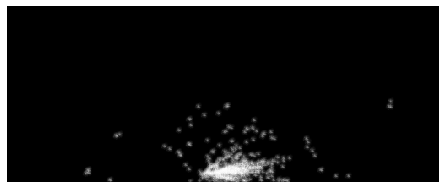

In [0]:
# Heat maps
names = ['ResBlock1','ResBlock2','ResBlock3','ResBlock4','Bridge',
         'TransConvBlock4','TransConvBlock3','TransConvBlock2','TransConvBlock1']
for name in names:
    act = activation[name].squeeze()
    for img_idx in [3, 19, 26, 27, 37]:
        tot_act = torch.sum(act[img_idx], dim=0)
        plt.axis('off')
        plt.imshow(tot_act, cmap=plt.get_cmap("Greys_r"))
        plt.tight_layout(pad=0)
        iu.save_figure(plt, f"{name}_{img_idx}_heatmap")

torch.Size([16, 1, 3, 3])
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


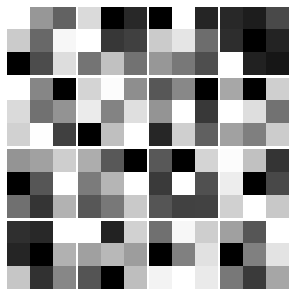

In [0]:
filters = model.c1.conv1.weight.data
print(filters.size())
N = filters.size(0)
choices = np.sort(np.random.choice(list(range(N)), size = 16, replace = False))
# First conv has only 1 input channel, but subsequent conv can have many
filters = filters[choices, 0]
N = filters.size(0)
grid = 4
fig, ax = plt.subplots(N // grid, N // grid, figsize=(grid,grid))
print(choices)
for filter_idx in range(N):
    ax[filter_idx // grid, filter_idx % grid].axis('off')
    ax[filter_idx // grid, filter_idx % grid].imshow(filters[filter_idx], cmap=plt.get_cmap("Greys_r"))
plt.tight_layout(pad=0.3)
iu.save_figure(plt, f"ResBlock1_Conv1_{filter_idx}")

In [0]:
imgs = None
for batch in bunch.valid_dl:
    imgs, _ = batch
    break
imgs.shape[0]

48

In [0]:
# Training stats
batch_lrs = np.concatenate([i.learning_rates for i in info])
batch_losses = np.concatenate([s.get_losses() for s in stats])
batch_overall_accuracies = np.concatenate([s.get_accuracies() for s in stats])
batch_track_accuracies = np.concatenate([s.get_accuracies(TRACK) for s in stats])
batch_shower_accuracies = np.concatenate([s.get_accuracies(SHOWER) for s in stats])
batch_accuracies = np.array([batch_overall_accuracies, batch_track_accuracies, batch_shower_accuracies])

np.save("learning_rates", batch_lrs)
np.save("losses", batch_losses)
np.save("accuracies", batch_overall_accuracies)
np.save("track_accuracies", batch_track_accuracies)
np.save("shower_accuracies", batch_shower_accuracies)

In [0]:
# Validation stats
batch_val_losses = np.concatenate([s.get_losses() for s in val_stats])
batch_val_overall_accuracies = np.concatenate([s.get_accuracies() for s in val_stats])
batch_val_track_accuracies = np.concatenate([s.get_accuracies(TRACK) for s in val_stats])
batch_val_shower_accuracies = np.concatenate([s.get_accuracies(SHOWER) for s in val_stats])
batch_val_accuracies = np.array([batch_val_overall_accuracies, batch_val_track_accuracies, batch_val_shower_accuracies])

np.save("val_losses", batch_val_losses)
np.save("val_accuracies", batch_val_overall_accuracies)
np.save("val_track_accuracies", batch_val_track_accuracies)
np.save("val_shower_accuracies", batch_val_shower_accuracies)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


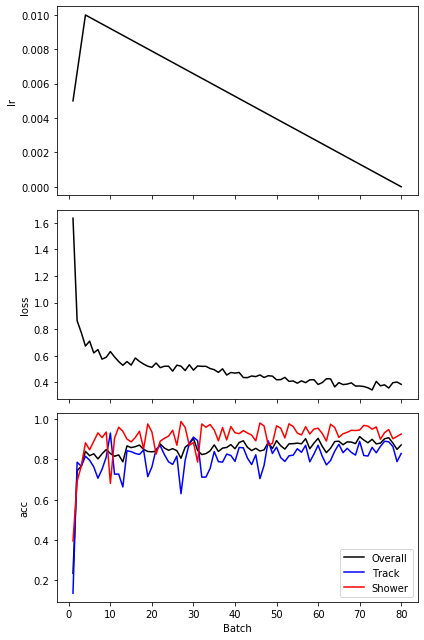

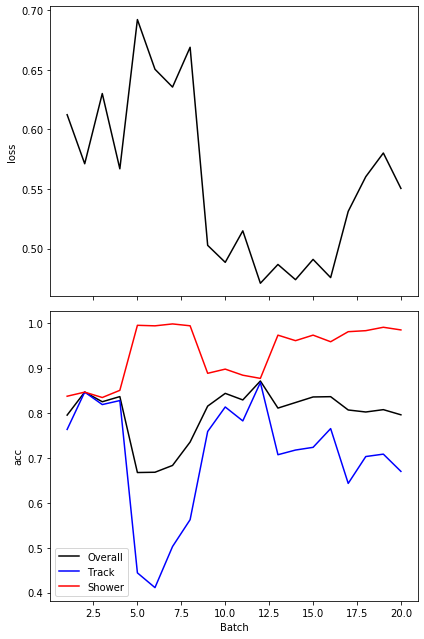

In [0]:
plot_lr_loss_acc(batch_lrs, batch_losses, batch_accuracies, "LRLossAccByBatch")
plot_loss_acc(batch_val_losses, batch_val_accuracies, "LossAccByBatch")

In [0]:
# Upload pickle files
from google.colab import files
files.upload()

Saving flat_acc.npy to flat_acc.npy
Saving flat_losses.npy to flat_losses.npy
Saving flat_lr.npy to flat_lr.npy


{'flat_acc.npy': b"\x93NUMPY\x01\x00v\x00{'descr': '<f8', 'fortran_order': False, 'shape': (85,), }                                                           \n\x00\x00\x00`;\x8f\xe0?\x00\x00\x00`\x84\x1b\xe4?\x00\x00\x00\x80_r\xe7?\x00\x00\x00`=\xa3\xe6?\x00\x00\x00\x80\xbcU\xe7?\x00\x00\x00\x00\x1c\x88\xe8?\x00\x00\x00 Q9\xe8?\x00\x00\x00`\x00\xa1\xe8?\x00\x00\x00\xc0\xa5a\xea?\x00\x00\x00@\x10\xd5\xe9?\x00\x00\x00 c#\xe9?\x00\x00\x00\xe0\xae\x8b\xea?\x00\x00\x00\x80$\x80\xe9?\x00\x00\x00 \x03\xa6\xe9?\x00\x00\x00\xa0\x7f\xf7\xe9?\x00\x00\x00 \xb0o\xe9?\x00\x00\x00\xa0\xbfv\xea?\x00\x00\x00\xe08\x05\xea?\x00\x00\x00`\x1e\x90\xea?\x00\x00\x00\xa0?.\xeb?\x00\x00\x00\x80m\xbc\xea?\x00\x00\x00 \xec\xec\xe9?\x00\x00\x00\xc0\xdd\x16\xea?\x00\x00\x00 \xa2F\xea?\x00\x00\x00\x80\xa5\x16\xeb?\x00\x00\x00 \x91\xb9\xeb?\x00\x00\x00`\xd5\x99\xeb?\x00\x00\x00\x00q\xc0\xeb?\x00\x00\x00\xe0\xb9n\xeb?\x00\x00\x00`\x01h\xe9?\x00\x00\x00 \x84\r\xec?\x00\x00\x00 Ue\xec?\x00\x00\x00\x00\x92\x1e\xea?\x00\

In [0]:
# Upload some comparison data
import numpy as np
learning_rates = np.load("flat_lr.npy")
train_loss_batches = np.load("flat_losses.npy")
train_acc_batches = np.load("flat_acc.npy")

In [0]:
# Upload pickle files
!rm -f cycle_*.npy 
from google.colab import files
files.upload()

Saving cycle_acc.npy to cycle_acc.npy
Saving cycle_losses.npy to cycle_losses.npy
Saving cycle_lr.npy to cycle_lr.npy


{'cycle_acc.npy': b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<f8\', \'fortran_order\': False, \'shape\': (85,), }                                                           \n\x00\x00\x00\x80\x8f\x0b\xdf?\x00\x00\x00\xc0\xc8\x0c\xe6?\x00\x00\x00\xa0Z\x8b\xe7?\x00\x00\x00`R\x82\xe5?\x00\x00\x00`\xdc+\xe7?\x00\x00\x00\xc0\x99b\xe8?\x00\x00\x00\x00&\xe3\xe8?\x00\x00\x00@\xf6N\xe9?\x00\x00\x00\xc0\xefN\xea?\x00\x00\x00\xc0\xbd.\xeb?\x00\x00\x00 \x98C\xea?\x00\x00\x00@(\x01\xea?\x00\x00\x00\x00\x84\x96\xeb?\x00\x00\x00\xe02W\xeb?\x00\x00\x00 \xce\x13\xea?\x00\x00\x00\x00\x16\xbc\xeb?\x00\x00\x00\x00\x8f^\xe6?\x00\x00\x00 \xe1N\xeb?\x00\x00\x00@U\xe0\xe9?\x00\x00\x00 ~\xc4\xe9?\x00\x00\x00\x80\x97;\xea?\x00\x00\x00\x80\x18.\xea?\x00\x00\x00\x80W\\\xe8?\x00\x00\x00\x00&$\xeb?\x00\x00\x00`\xf29\xea?\x00\x00\x00\xa0O"\xea?\x00\x00\x00`\x9f\xc0\xea?\x00\x00\x00 \xceW\xeb?\x00\x00\x00\xa0D\xff\xe9?\x00\x00\x00 <\xfe\xe9?\x00\x00\x00@o\xa2\xeb?\x00\x00\x00\x80\xcb\x86\xeb?\x00\x00\x00@M\x10\xeb?\x00\x00

In [0]:
cycle_lr = np.load("cycle_lr.npy")
cycle_losses = np.load("cycle_losses.npy")
cycle_acc = np.load("cycle_acc.npy")

In [0]:
def plot_multi_lr_loss_acc(lrs, losses, accuracies, lrs2, losses2, acc2, name):
    fig, axs = plt.subplots(2, 1, sharex=True)
    xx = list(range(1, 1 + len(lrs)))
    yy_flat = [lrs, losses, accuracies]
    yy_cycle = [lrs2, losses2, acc2]
    xlabels = ["lr", "loss", "acc"]
    labels = ["Constant", "One-Cycle"]
    colors = [['black', 'black', 'black'],['red', 'red', 'red']]
    for i, ax in enumerate(axs):
        ax.set_xlabel("Batch")
        ax.set_ylabel(xlabels[i])
        ax.plot(xx, yy_flat[i], c=colors[0][i], label=labels[0])
        ax.plot(xx, yy_cycle[i], c=colors[1][i], label=labels[1])
    axs[0].legend()
    for ax in axs: ax.label_outer()
    plt.tight_layout()
    iu.save_figure(fig, name)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


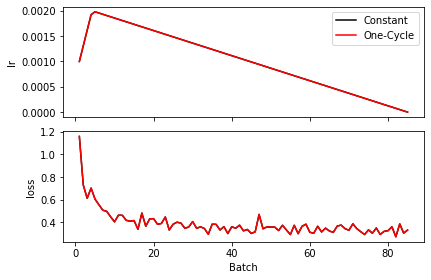

In [0]:
plot_multi_lr_loss_acc(learning_rates, train_loss_batches, train_acc_batches, cycle_lr, cycle_losses, cycle_acc, "MultiLRLossAcc")

In [0]:
#del x, y
#del images, masks
#del model
torch.cuda.empty_cache()

In [0]:
def plot_stat_epoch(train_stats, val_stats, stat="Loss"):
    epochs = np.array(list(range(1, len(train_stats) + 1)), dtype=np.int16)
    fig, ax = plt.subplots()
    ax.set_title(f'Model {stat}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(f'{stat}')
    ax.plot(epochs, train_stats, label='Training', c='red')
    ax.plot(epochs, val_stats, label='Validation', c='blue')
    if stat == "Loss": ax.legend(loc='upper right')
    else: ax.legend(loc='upper left')
    iu.save_figure(plt, f"Average{stat}VsTrainingEpoch")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


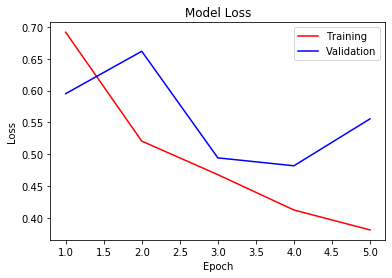

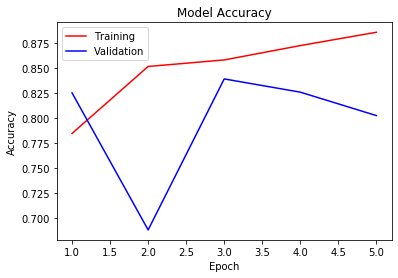

In [0]:
train_loss_epochs = [s.get_losses().mean() for s in stats]
val_loss_epochs = [s.get_losses().mean() for s in val_stats]
plot_stat_epoch(train_loss_epochs, val_loss_epochs)

train_acc_epochs = [s.get_accuracies().mean() for s in stats]
val_acc_epochs = [s.get_accuracies().mean() for s in val_stats]
plot_stat_epoch(train_acc_epochs, val_acc_epochs, stat="Accuracy")

In [0]:
!tar cvzf images.tar.gz *.png *.pdf *.eps *.npy
#!tar cvzf images.tar.gz *.pdf
files.download("images.tar.gz")

DetailByBatch.png
DetailByEpoch.png
LRLossAccByBatch.png
TrainingByBatch.png
TrainingByEpoch.png
DetailByBatch.pdf
DetailByEpoch.pdf
LRLossAccByBatch.pdf
TrainingByBatch.pdf
TrainingByEpoch.pdf
DetailByBatch.eps
DetailByEpoch.eps
LRLossAccByBatch.eps
TrainingByBatch.eps
TrainingByEpoch.eps
tar: *.npy: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


In [0]:
!tar cvzf models.tar.gz *.pkl
files.download("models.tar.gz")

unet_0.pkl
unet_1.pkl
unet_2.pkl
unet_3.pkl
unet_4.pkl


In [0]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [0]:
dump_tensors()

Total size: 0


/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: MODES has been renamed to Modes and will be removed in a future version of pywt.


In [0]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_single(img, name, **kwargs):
    plt.imshow(img, **kwargs)
    plt.axis('off')
    plt.tight_layout()
    iu.save_figure(plt, f"validation_{name}")

def render_batch(inputs, predictions, masks, void_code):
    print(inputs.shape)
    N = inputs.shape[0]
    cmap_rb = ListedColormap(['black', 'red', 'blue'])
    norm_rb = BoundaryNorm([0., 0.5, 1.5, 2.], cmap_rb.N)
    xtr_rb = dict(cmap=cmap_rb, norm=norm_rb, alpha=1.0)

    cmap_w = ListedColormap(['black', 'white'])
    norm_w = BoundaryNorm([0., 0.5, 1.], cmap_w.N)
    xtr_w = dict(cmap=cmap_w, norm=norm_w, alpha=1.0)

    raw = inputs[:,0]
    pred_masks = iu.imagify(inputs, predictions, masks, void_code, N, False)

    for i, img in enumerate(raw):
        plot_single(img, f"raw_{i}", **xtr_w)

    for i, (pred, mask) in enumerate(pred_masks):
        plot_single(pred, f"pred_{i}", **xtr_rb)
        plot_single(mask, f"mask_{i}", **xtr_rb)

torch.Size([48, 1, 208, 512]) torch.Size([48, 208, 512])
(48, 1, 208, 512)


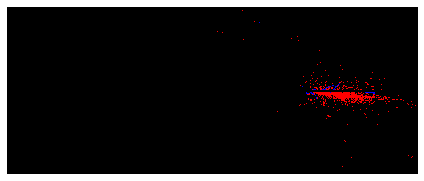

In [0]:
# Load and eval - simplify this, just get the last batch in the validation
# set, pass that through the network and display the output imagde and
# the prediction as separate images for ease of use in presentation
# Run
model.load_state_dict(torch.load("unet_0.pkl"))
model.eval()

for group in model.children():
    if type(group) == nn.Sequential:
        for child in group:
            if type(child)==nn.BatchNorm2d:
                child.track_running_stats = False

with torch.no_grad():
    dl = bunch.valid_dl
    for i, batch in enumerate(dl):
        if i < (len(dl) - 1): continue
        images, masks = batch
        print(images.size(), masks.size())
        x = Variable(images)
        y = Variable(masks)
        pred = model.forward(x)

        net_input = x.detach().numpy()
        net_pred = pred.detach().numpy()
        net_mask = y.detach().numpy()
        render_batch(net_input, net_pred, net_mask, void_code)

In [0]:
!tar cvzf images.tar.gz *.pdf
files.download("images.tar.gz")

validation_mask_0.pdf
validation_mask_10.pdf
validation_mask_11.pdf
validation_mask_12.pdf
validation_mask_13.pdf
validation_mask_14.pdf
validation_mask_15.pdf
validation_mask_16.pdf
validation_mask_17.pdf
validation_mask_18.pdf
validation_mask_19.pdf
validation_mask_1.pdf
validation_mask_20.pdf
validation_mask_21.pdf
validation_mask_22.pdf
validation_mask_23.pdf
validation_mask_24.pdf
validation_mask_25.pdf
validation_mask_26.pdf
validation_mask_27.pdf
validation_mask_28.pdf
validation_mask_29.pdf
validation_mask_2.pdf
validation_mask_30.pdf
validation_mask_31.pdf
validation_mask_32.pdf
validation_mask_33.pdf
validation_mask_34.pdf
validation_mask_35.pdf
validation_mask_36.pdf
validation_mask_37.pdf
validation_mask_38.pdf
validation_mask_39.pdf
validation_mask_3.pdf
validation_mask_40.pdf
validation_mask_41.pdf
validation_mask_42.pdf
validation_mask_43.pdf
validation_mask_44.pdf
validation_mask_45.pdf
validation_mask_46.pdf
validation_mask_47.pdf
validation_mask_4.pdf
validation_mask_